<h1 style="font-size:300%">X-ray wrist classifier</h1>

This notebook is a fun assignment that uses [PyTorch Lightning](https://lightning.ai/pytorch-lightning) and transfer learning to fine tune a pretrained model for image classification to classify images of x-rays of the wrist. In this classifier we are going to look at x-rays that do or don't have a cast and are broken or not. We use a subset of the [Wrist X-ray dataset](https://ruiyangju.github.io/GRAZPEDWRI-DX_JU/) by Rui-Yany Ju. 

![X-ray robot.png](<attachment:X-ray robot.png>)
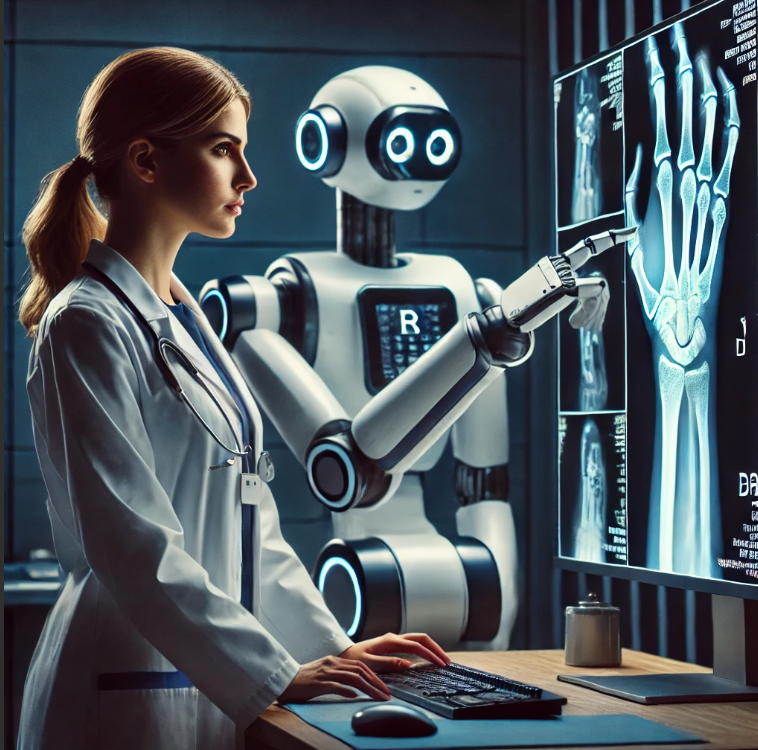

In [5]:
import os, pandas, platform, torch, torchvision, pytorch_lightning

torch.manual_seed(42)

data_path = "D:\\Minor\\Classification\\Pols x-ray\\Data"

print("Versions: python", platform.python_version(), "| torch", torch.__version__, "| torchvision", torchvision.__version__, "| pytorch_lightning", pytorch_lightning.__version__, "| pandas", pandas.__version__)

Versions: python 3.13.2 | torch 2.6.0+cpu | torchvision 0.21.0+cpu | pytorch_lightning 2.5.0.post0 | pandas 2.2.3


In [6]:
from torchvision import models

pretrained_model = models.resnet18(weights="DEFAULT")

In [ ]:
for i in range(5):
    img, label = dataset.data[i]
    
    img = img.permute(1,2,0)
    print(img.shape[0])
    #print(img)
    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            img[y][x] = int(img[y][x] * 255.0)
    print(img)
    plt.imshow(img, cmap="gray",vmin=0,vmax=255)
    plt.title(f"Label: {label}")
    plt.show()

NameError: name 'dataset' is not defined

In [7]:
from torchvision import transforms

image_size = (244, 244)

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize(image_size),
    transforms.ToTensor(),
])

In [8]:
from pytorch_lightning import LightningDataModule
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

class ImageFolderDataSet(LightningDataModule):
    def __init__(self, path, transform, split=[.7, .2, .1], batch_size=32, num_workers=int(os.cpu_count()/2)):
        super().__init__()
        self.path = path
        self.split = split
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transform

    def setup(self, stage=None):
        self.data = ImageFolder(self.path, transform=self.transform)
        self.train, self.val, self.test = random_split(self.data, self.split)

    def train_dataloader(self):
        return DataLoader(self.train, shuffle=True, batch_size=self.batch_size, num_workers=self.num_workers, persistent_workers=True)
    
    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size, num_workers=self.num_workers, persistent_workers=True)
    
    def test_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size, num_workers=self.num_workers, persistent_workers=True)

    def classes(self):
        return self.data.classes



dataset = ImageFolderDataSet(data_path, transform)
dataset.setup()
classes = dataset.classes()
print("Created an image dataset for classes:", classes)

Created an image dataset for classes: ['AP #', 'AP non #', 'Cast # AP', 'Cast # L', 'Cast non AP', 'Cast non L', 'L #', 'L non #']


In [9]:
from pytorch_lightning import LightningModule
from torch import nn
import torch
import torch.nn.functional as F
from torchmetrics import Accuracy, Precision, Recall

class ImageClassifierModel(LightningModule):
    def __init__(self, pretrained_model, num_classes, freeze_layers=True):
        super().__init__()
        self.num_classes = num_classes
        self.model = pretrained_model
        if freeze_layers:
            for param in self.model.parameters(): 
                param.requires_grad = False
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes=self.num_classes, average="none")
        self.precision = Precision(task="multiclass", num_classes=self.num_classes, average="none")
        self.recall = Recall(task="multiclass", num_classes=self.num_classes, average="none") 
    
    def forward(self, x):
        return self.model(x)
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.002) 

    def training_step(self, batch):
        x, y = batch
        logits = self(x)
        return self.criterion(logits, y)
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        
        preds = torch.argmax(y_hat, dim=1)
        acc = (preds == y).float().mean()  # Bereken accuratesse
        
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_accuracy", acc, prog_bar=True)  # Log accuratesse

    def test_step(self, batch):
        x, y = batch
        logits = self(x)
        preds = logits.argmax(dim=1)
        self.accuracy(preds, y)
        self.precision(preds, y)
        self.recall(preds, y)
    
    def predict_step(self, batch):
        x, y = batch
        logits = self(x)
        return logits

    def on_test_epoch_end(self):
        accuracy = self.accuracy.compute()
        precision = self.precision.compute()
        recall = self.recall.compute()
        for i in range(self.num_classes):
            self.log("test_accuracy_class_" + str(i), accuracy[i])
            self.log("test_precision_class_" + str(i), precision[i])
            self.log("test_recall_class_" + str(i), recall[i])

model = ImageClassifierModel(pretrained_model, num_classes=len(classes))


In [10]:
from pytorch_lightning.loggers import CSVLogger 
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning import Trainer

logger = CSVLogger(save_dir=".")

early_stopping = EarlyStopping(
    monitor="val_accuracy", 
    patience=10, 
    mode="max", 
    stopping_threshold= 1.0
)

trainer = Trainer(max_epochs=100, logger=logger, callbacks=[early_stopping])
trainer.fit(model, datamodule=dataset)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type                | Params | Mode 
----------------------------------------------------------
0 | model     | ResNet              | 11.2 M | train
1 | criterion | CrossEntropyLoss    | 0      | train
2 | accuracy  | MulticlassAccuracy  | 0      | train
3 | precision | MulticlassPrecision | 0      | train
4 | recall    | MulticlassRecall    | 0      | train
----------------------------------------------------------
4.1 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.722    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[32, 1, 244, 244] to have 3 channels, but got 1 channels instead

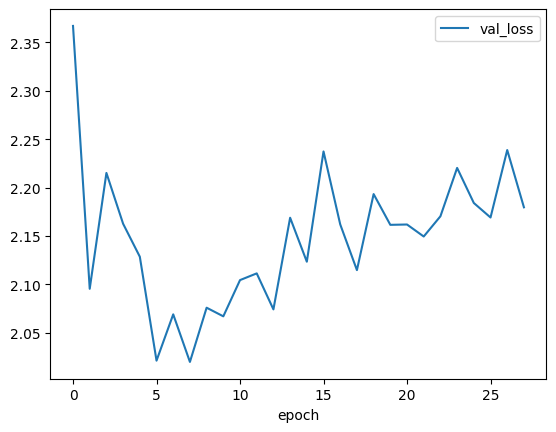

In [ ]:
metrics = pandas.read_csv(os.path.join(trainer.log_dir, "metrics.csv"))
loss_metrics = metrics[["epoch", "val_loss"]].set_index("epoch")
plot = loss_metrics.plot()

In [ ]:
scores = trainer.test(model, datamodule=dataset, verbose=False)
accuracies = [scores[0]["test_accuracy_class_" + str(i)] for i in range(len(classes))]
precisions = [scores[0]["test_precision_class_" + str(i)] for i in range(len(classes))]
recalls = [scores[0]["test_recall_class_" + str(i)] for i in range(len(classes))]
df = pandas.DataFrame({"class": classes, "accuracy": accuracies, "precision": precisions, "recall": recalls}).set_index("class")
df

Testing DataLoader 0: 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]


,accuracy,precision,recall
class,,,
AP #,0.500000,0.500000,0.500000
AP non #,0.500000,0.666667,0.500000
Cast # AP,0.666667,0.500000,0.666667
Cast # L,0.250000,1.000000,0.250000
Cast non AP,0.500000,1.000000,0.500000
Cast non L,0.625000,0.454545,0.625000
L #,0.600000,0.333333,0.600000
L non #,0.375000,0.428571,0.375000


In [ ]:
#inference_folder = ImageFolder(inference_path, transform=transform)
#inference_dataloader = DataLoader(inference_folder, batch_size=32, num_workers=int(os.cpu_count()/2), persistent_workers=True)
inference_dataloader = dataset.test_dataloader()
preds = trainer.predict(model, dataloaders=inference_dataloader)
predictions = torch.cat(preds)
images = torch.cat([x for x, y in inference_dataloader])
labels = torch.cat([y for x, y in inference_dataloader])

Predicting DataLoader 0: 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]


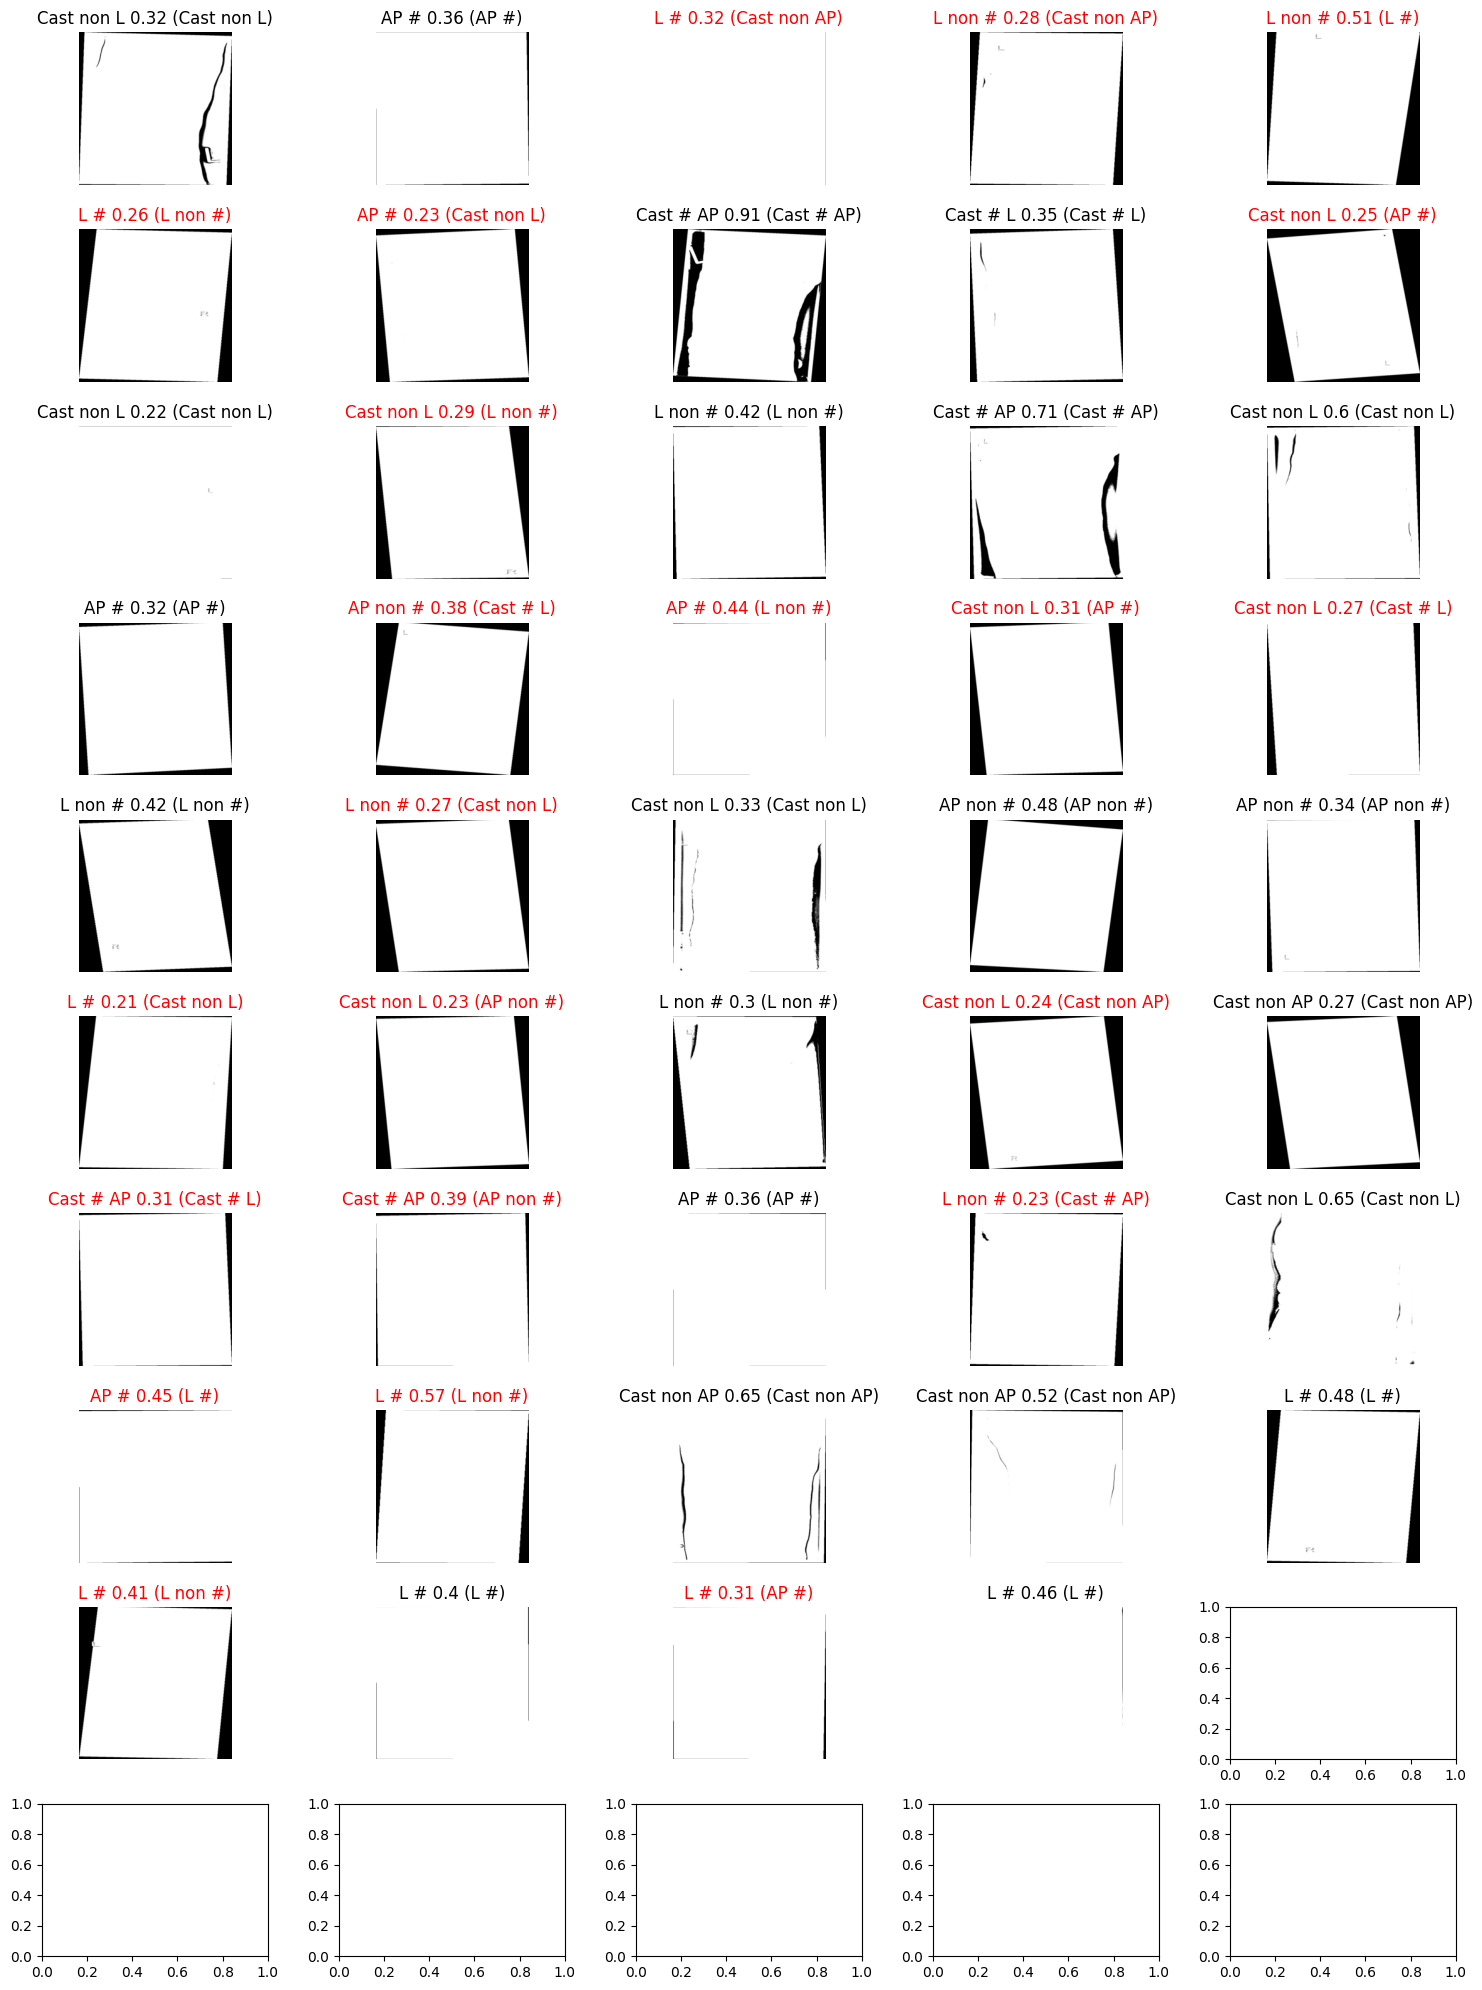

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(10, 5, figsize=(15, 20))
axs = axs.flatten()
for i, (image, truth, prediction) in enumerate(zip(images, labels, predictions)):
    probabilities = torch.softmax(prediction, dim=0)
    pred_class = torch.argmax(probabilities)
    pred_prob = probabilities[pred_class].item()
    pred_label = classes[pred_class]
    truth_label = classes[truth.item()]
    axs[i].imshow(image.permute(1, 2, 0).numpy())
    axs[i].set_title(pred_label + " " + str(round(pred_prob,2)) + " ("+ truth_label+")", color="red" if pred_label != truth_label else "black")
    axs[i].axis("off")
plt.tight_layout()
plt.show()

NameError: name 'images' is not defined

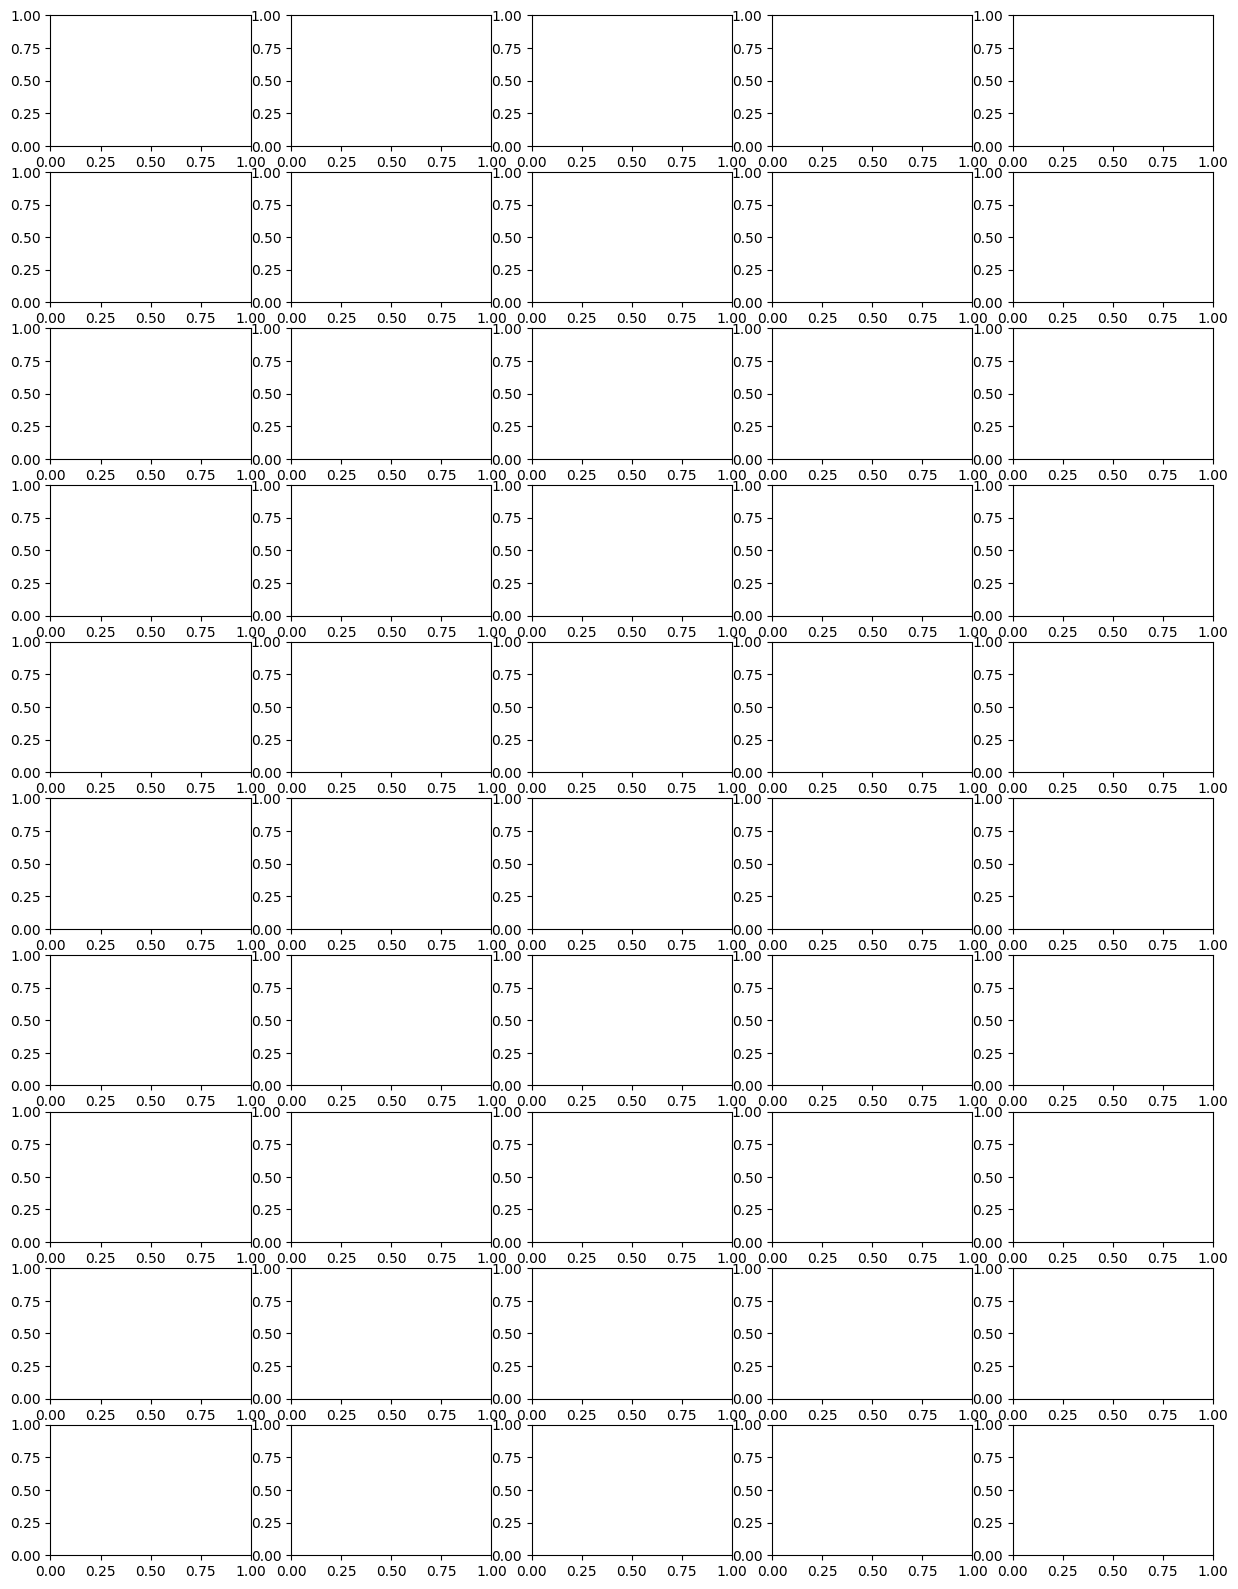

In [ ]:
import torch
import matplotlib.pyplot as plt

fig, axs = plt.subplots(10, 5, figsize=(15, 20))
axs = axs.flatten()

for i, (image, truth, prediction) in enumerate(zip(images, labels, predictions)):
    probabilities = torch.sigmoid(prediction)  # Gebruik sigmoid voor multi-label classificatie
    pred_probs = [round(prob.item(), 2) for prob in probabilities]  # Maak de kansen leesbaar
    truth_label = classes[truth.item()]  # Haal het echte label op
    
    # Maak een string met alle voorspellingen en hun waarschijnlijkheden
    pred_text = ", ".join([f"{classes[idx]} ({prob})" for idx, prob in enumerate(pred_probs)])

    axs[i].imshow(image.permute(1, 2, 0).numpy())  # Zet de afbeelding om naar een NumPy array
    axs[i].set_title(f"Voorspelling: {pred_text}\nEcht: {truth_label}", 
                     color="red" if classes[torch.argmax(probabilities)] != truth_label else "black")
    axs[i].axis("off")  # Zet de assen uit

plt.tight_layout()
plt.show()